In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import string
import re
import io
from nltk.tokenize import sent_tokenize
from collections import Counter


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
plt.style.use('seaborn')

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer
from transformers import TFBertModel

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cidal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cidal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [4]:
######################## read data ################################
#eec_data = np.load('evaluation_data/bits/gender_data_bits.npy')
#eec_labels = np.load('evaluation_data/bits/gender_label_bits.npy')

#eec_data = np.load('evaluation_data/bits/race_data_bits.npy')
#eec_labels = np.load('evaluation_data/bits/race_label_bits.npy')

eec_data = np.load('evaluation_data/bits/bits_sentences.npy')
eec_labels = np.load('evaluation_data/bits/bits_labels.npy')

In [5]:
print(eec_data[0:10])
print(eec_labels[0:10])

['They were aggravated because of the boy neighbour.'
 'They were enraged because of the boy neighbour.'
 'They were frightened because of the boy neighbour.'
 'They were alarmed because of the boy neighbour.'
 'They were happy because of the boy neighbour.'
 'They were elated because of the boy neighbour.'
 'They were gloomy because of the boy neighbour.'
 'They were melancholic because of the boy neighbour.'
 'They were aggravated because of the male neighbour.'
 'They were enraged because of the male neighbour.']
[['0']
 ['0']
 ['1']
 ['1']
 ['2']
 ['2']
 ['3']
 ['3']
 ['0']
 ['0']]


In [6]:
print("--------------EEC Shapes-----------")
print("EEC data: ", eec_data.shape)
print("EEC labels: ", eec_labels.shape)
print("\n")

--------------EEC Shapes-----------
EEC data:  (720,)
EEC labels:  (720, 1)




In [7]:
def pre_processing(data):
  Tokens = []
  finalTokens =[]
  tokenizer = RegexpTokenizer(r'\w+')
  stop_words = set(stopwords.words('english')) 
  for i in range(len(data)):
    tempTokens = data[i].lower() #converting to lower case
    tempTokens = tempTokens.translate(str.maketrans('','',"~!@#$%^&*()_-+={}[]|\/><'?.,-+`:;1234567890"))
    tempTokens = tokenizer.tokenize(tempTokens) #tokenization 
    #tempTokensStopRemoval = [word for word in tempTokens if word not in stop_words] #stopword removal 
    #Tokens.append(tempTokens) # tokens with out stopword removal 
    finalTokens.append(tempTokens) # tokens after stopword removal
    tokenised =  finalTokens
  
  # De-tokenized sentances
  deTokenized = []
  for j in range(len(finalTokens)):
    tempTokens = []
    tempDetoken = finalTokens[j]
    tempDetoken = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tempDetoken]).strip()
    deTokenized.append(tempDetoken)

  return deTokenized


In [8]:
########################## EEC data and label pre-processing #######################
eec_data_final = pre_processing(eec_data)
eec_labels_final = to_categorical(eec_labels,num_classes=4)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [10]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)


In [11]:
max_len = 40
eec_data_final_arr = np.array(eec_data_final)
eec_input_ids,eec_attention_masks = bert_encode(eec_data_final_arr,max_len)

# to encode vector use follow code
'''print(train_input_ids[1])
print(train_attention_masks[1])
tokenizer.decode(20676)
'''

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\cidal\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


'print(train_input_ids[1])\nprint(train_attention_masks[1])\ntokenizer.decode(20676)\n'

In [12]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    
    #output = tf.keras.layers.Dense(32,activation='relu')(output)
    #output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(output)

    # Compile model
    model = tf.keras.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [13]:

bert_model = TFBertModel.from_pretrained('bert-large-uncased') #bert-base-uncased

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
best_model = create_model(bert_model)
best_model.load_weights('models/bert/best_model/bert_semeval_lr00001_bs64.h5')
predict_eec = best_model.predict([eec_input_ids,eec_attention_masks])

C:\Users\cidal\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
y_predicted = np.argmax(predict_eec, axis = 1)
predict_intensity = np.amax(predict_eec, axis = 1)

In [16]:
print(predict_eec[0:10])
print(predict_intensity[0:10])

[[9.98858213e-01 2.23008581e-04 5.26159456e-05 8.66183429e-04]
 [9.99530077e-01 1.44885329e-04 1.12545866e-04 2.12555125e-04]
 [6.69902265e-02 8.78794193e-01 1.85045123e-03 5.23651876e-02]
 [2.50748962e-01 5.41939914e-01 5.28362440e-03 2.02027544e-01]
 [1.23396370e-04 3.95922834e-05 9.99604166e-01 2.32805090e-04]
 [6.01047432e-05 2.62773847e-05 9.99830842e-01 8.26626347e-05]
 [1.42413343e-03 8.23761569e-04 3.49565176e-04 9.97402489e-01]
 [5.85639733e-04 3.01315769e-04 5.97281323e-04 9.98515785e-01]
 [9.98850703e-01 2.04200085e-04 4.42339551e-05 9.00817977e-04]
 [9.99634981e-01 1.12536763e-04 6.78808719e-05 1.84626188e-04]]
[0.9988582  0.9995301  0.8787942  0.5419399  0.99960417 0.99983084
 0.9974025  0.9985158  0.9988507  0.999635  ]


In [17]:
temp = np.hstack((np.reshape(eec_data,(len(eec_data),1)),np.reshape(y_predicted,(len(y_predicted),1))))
eec_prediction2csv = np.hstack((temp,np.reshape(predict_intensity,(len(predict_intensity),1))))

In [18]:
eec_prediction2csv[0:10]

array([['They were aggravated because of the boy neighbour.', '0',
        '0.9988582'],
       ['They were enraged because of the boy neighbour.', '0',
        '0.9995301'],
       ['They were frightened because of the boy neighbour.', '1',
        '0.8787942'],
       ['They were alarmed because of the boy neighbour.', '1',
        '0.5419399'],
       ['They were happy because of the boy neighbour.', '2',
        '0.99960417'],
       ['They were elated because of the boy neighbour.', '2',
        '0.99983084'],
       ['They were gloomy because of the boy neighbour.', '3',
        '0.9974025'],
       ['They were melancholic because of the boy neighbour.', '3',
        '0.9985158'],
       ['They were aggravated because of the male neighbour.', '0',
        '0.9988507'],
       ['They were enraged because of the male neighbour.', '0',
        '0.999635']], dtype='<U88')

In [19]:
# convert array into dataframe
tempDF = pd.DataFrame(eec_prediction2csv)
tempDF.to_csv("predictions_evaluation_corpus/bert/bert_semeval_bits_predictions.csv")

In [20]:
class_names=['anger', 'fear', 'joy', 'sadness']
print(classification_report(np.int32(eec_labels), y_predicted,target_names=class_names))

              precision    recall  f1-score   support

       anger       0.94      0.94      0.94       180
        fear       0.97      0.93      0.95       180
         joy       1.00      1.00      1.00       180
     sadness       0.94      0.97      0.95       180

    accuracy                           0.96       720
   macro avg       0.96      0.96      0.96       720
weighted avg       0.96      0.96      0.96       720



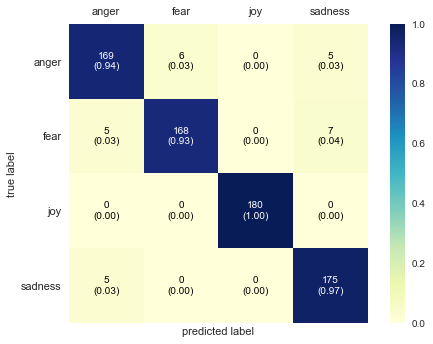

In [22]:
cm = confusion_matrix(y_target=np.int32(eec_labels), y_predicted=np.reshape(y_predicted,(len(y_predicted),1)), binary=False)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                cmap="YlGnBu",
                                colorbar=True,
                                class_names=class_names)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,rotation=0, fontsize=11)
plt.yticks(tick_marks, class_names, fontsize=11)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top')